In [1]:
import os
import json
import imageio
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms

from lib import utils, tri_dvgo_multiscene

Using /home/hydeng/.cache/torch_extensions as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/hydeng/.cache/torch_extensions/adam_upd_cuda/build.ninja...
Building extension module adam_upd_cuda...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
ninja: no work to do.
Loading extension module adam_upd_cuda...
Using /home/hydeng/.cache/torch_extensions as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/hydeng/.cache/torch_extensions/render_utils_cuda/build.ninja...
Building extension module render_utils_cuda...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
ninja: no work to do.
Loading extension module render_utils_cuda...


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
model_class = tri_dvgo_multiscene.DirectVoxGO
# ckpt_path = 'logs/tri_dvgo_multiscene/nerf_synthetic/rnd_liif_posemb_conv_down1/fine_last.tar'
# ckpt_path = 'logs/tri_dvgo_multiscene/nerf_synthetic/3conv_liif_pretrain_down4/fine_last.tar'
# ckpt_path = 'logs/tri_dvgo_multiscene/nerf_synthetic/3conv_liif_pretrain_down4_cosine/fine_last.tar'
# ckpt_path = 'logs/tri_dvgo_multiscene/nerf_synthetic/3conv_liif_pretrain_down4_cosine_featunfold/fine_330000.tar'

ckpt_path = 'logs/tri_dvgo_multiscene/nerf_synthetic/1conv+stn_liif_scratch_coarse+fine/fine_last.tar'

# ckpt_path = 'logs/tri_dvgo_multiscene/nerf_synthetic/3MLP_liif_pretrain_down4/fine_last.tar'
# ckpt_path = 'logs/tri_dvgo_multiscene/nerf_synthetic/MLP_liif_pretrain_down4/fine_last.tar'

In [4]:
model = utils.load_model(model_class, ckpt_path)

initialized encoder networks
initialized mapping networks
dvgo: set density bias shift to -4.595119850134584

dvgo: voxel_size       4096000
dvgo: voxel_size       tensor(0.0164, device='cuda:0')
dvgo: world_size       tensor([172, 170, 139], device='cuda:0')
dvgo: voxel_size_base  tensor(0.0164, device='cuda:0')
dvgo: voxel_size_ratio tensor(1., device='cuda:0')

implicit voxel feat!!!
dvgo: dim0               68
dvgo: feat_unfold        False
dvgo: cell_decode        True
64
dvgo: mlp Sequential(
  (0): Linear(in_features=91, out_features=128, bias=True)
  (1): ReLU(inplace=True)
  (2): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU(inplace=True)
  )
  (3): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU(inplace=True)
  )
  (4): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU(inplace=True)
  )
  (5): Linear(in_features=128, out_features=3, bias=True)
)
loaded check

In [5]:
def read_image(path):
    image = imageio.imread(path)
    image = (np.array(image) / 255.).astype(np.float32)
    if image.shape[-1] == 4:
        image = image[...,:3]*image[...,-1:] + (1.-image[...,-1:])
    return image

In [6]:
def read_poses(path, idxs):
    with open(path, 'r') as f:
        meta = json.load(f)
    poses = []
    for id in idxs:
        frame = meta['frames'][id]
        poses.append(np.array(frame['transform_matrix']))
    poses = np.stack(poses)
    return poses

In [7]:
imagedir = '/home/hydeng/data/NeRF_data/nerf_synthetic/lego/train'
json_path = '/home/hydeng/data/NeRF_data/nerf_synthetic/lego/transforms_train.json'
idxs = [34, 49, 63]

images = []
for id in idxs:
    path = os.path.join(imagedir, f'r_{id}.png')
    images.append(read_image(path))
images = np.stack(images)

poses = read_poses(json_path, idxs)

images = torch.FloatTensor(images)
poses = torch.FloatTensor(poses)

In [8]:
print(images.shape, poses.shape)

torch.Size([3, 800, 800, 3]) torch.Size([3, 4, 4])


In [9]:
images = images.permute(0, 3, 1, 2)
h, w = images.shape[-2:]
h, w = h // 4, w // 4
resize = transforms.Resize([h, w])
images = resize(images)
images = (images - 0.5) / 0.5

In [10]:
mapped_feats, feats, _, _, = model.encode_feat(images, poses)

In [11]:
backbone_feats = model.backbone_encode(images)

In [12]:
print(backbone_feats.shape)

torch.Size([3, 64, 200, 200])


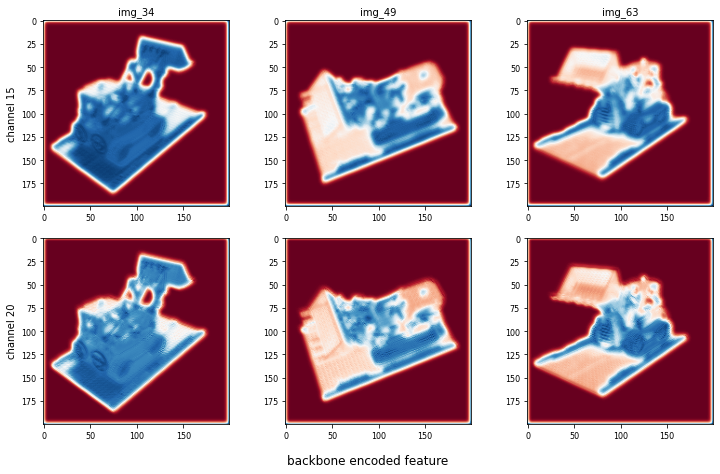

In [36]:
splits = [[0],[1],[2]]
channels = [15, 20]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=0.3, hspace=0)
vmin, vmax = 1e6, -1e6
for i, s in enumerate(splits):
    backbone_feats[s] = (backbone_feats[s] - backbone_feats[s].min()) / (backbone_feats[s].max() - backbone_feats[s].min())
    
    vmin = min(backbone_feats[s].min().item(), vmin)
    vmax = max(backbone_feats[s].max().item(), vmax)

for i, channel in enumerate(channels):
    for j, s in enumerate(splits):
        axes[i, j].imshow(backbone_feats[s][0][channel].detach().numpy(), cmap='RdBu')
        axes[i, j].xaxis.set_tick_params(labelsize=8)
        axes[i, j].yaxis.set_tick_params(labelsize=8)

rows = [f'channel {i}' for i in channels]
cols = [f'img_{i}' for i in [34, 49, 63]]
for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=90, fontsize=10)

for ax, col in zip(axes[0], cols):
    ax.set_title(col, fontsize=10)

plt.suptitle('backbone encoded feature', y=0.1)
plt.show()

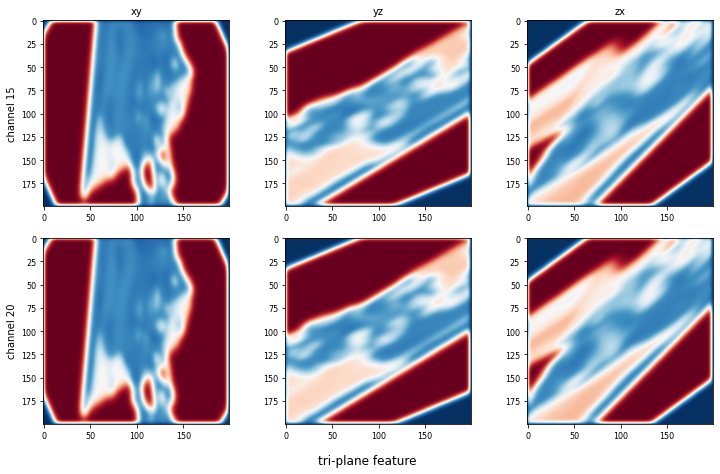

In [37]:
splits = ['xy', 'yz', 'zx']
channels = [15, 20]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=0.3, hspace=0)
vmin, vmax = 1e6, -1e6
for i, s in enumerate(splits):
    feats[s] = (feats[s] - feats[s].min()) / (feats[s].max() - feats[s].min())
    
    vmin = min(feats[s].min().item(), vmin)
    vmax = max(feats[s].max().item(), vmax)

for i, channel in enumerate(channels):
    for j, s in enumerate(splits):
        axes[i, j].imshow(feats[s][0][channel].detach().numpy(), cmap='RdBu')
        axes[i, j].xaxis.set_tick_params(labelsize=8)
        axes[i, j].yaxis.set_tick_params(labelsize=8)

rows = [f'channel {i}' for i in channels]
cols = splits
for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=90, fontsize=10)

for ax, col in zip(axes[0], cols):
    ax.set_title(col, fontsize=10)

    
plt.suptitle('tri-plane feature',y=0.1)
plt.show()

In [15]:
print(torch.cosine_similarity(feats['xy'][0][:, 0, 0].unsqueeze(0), feats['yz'][0][:, 0, 0].unsqueeze(0)))

tensor([1.0000], grad_fn=<DivBackward0>)


In [16]:
print(feats['xy'][0][:, 0, 0].shape)

torch.Size([64])


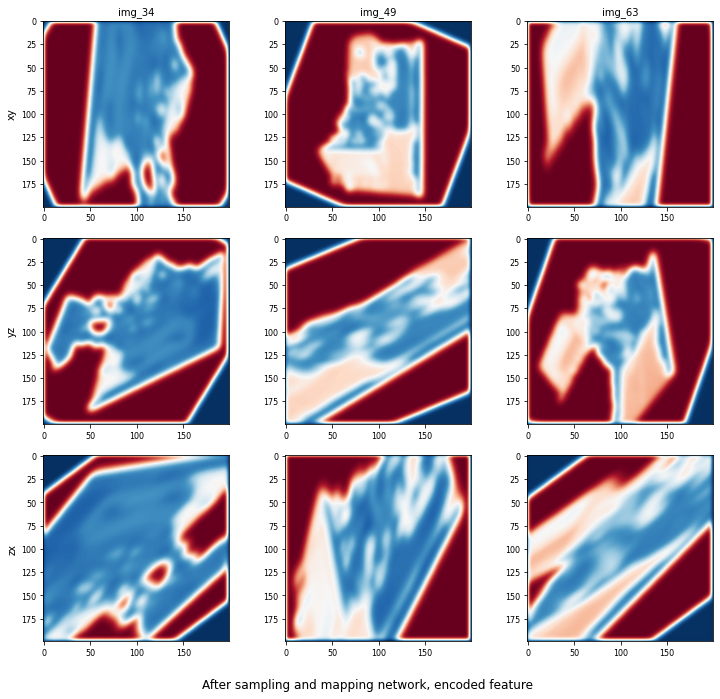

In [38]:
channels = 15
splits = [0, 1, 2]
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=0.3, hspace=0)
vmin, vmax = 1e6, -1e6
for i in splits:
    for j in splits:
        mapped_feats[i, j] = (mapped_feats[i, j] - mapped_feats[i, j].min()) / (mapped_feats[i, j].max() - mapped_feats[i, j].min())
    
    vmin = min(mapped_feats[i, j].min().item(), vmin)
    vmax = max(mapped_feats[i, j].max().item(), vmax)

for i in splits:
    for j in splits:
        axes[i, j].imshow(mapped_feats[i, j][channel].detach().numpy(), cmap='RdBu')
        axes[i, j].xaxis.set_tick_params(labelsize=8)
        axes[i, j].yaxis.set_tick_params(labelsize=8)

rows = ['xy', 'yz', 'zx']
cols = [f'img_{i}' for i in [34, 49, 63]]
for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=90, fontsize=10)

for ax, col in zip(axes[0], cols):
    ax.set_title(col, fontsize=10)

plt.suptitle('After sampling and mapping network, encoded feature',y=0.1)
plt.show()

In [18]:
print(F.mse_loss(mapped_feats[0, 0], mapped_feats[0, 1], reduction='sum'))

tensor(41877.5703, grad_fn=<MseLossBackward>)


In [19]:
print(F.cosine_similarity(mapped_feats[0, 0].detach(), mapped_feats[1, 0], dim=0).abs().sum())

tensor(38577.6094, grad_fn=<SumBackward0>)


In [20]:
cosine_loss = 0.
# if self.compute_cosine:
for k in range(3):
    similarity = 1/2. * F.cosine_similarity(mapped_feats[0, k].detach(), mapped_feats[1, k], dim=0).abs().sum() \
        + 1/2. * F.cosine_similarity(mapped_feats[0, k].detach(), mapped_feats[2, k], dim=0).abs().sum()
    cosine_loss += 1/3. * similarity
for k in range(3):
    similarity = 1/2. * F.cosine_similarity(mapped_feats[1, k].detach(), mapped_feats[0, k]).abs().sum() \
        + 1/2. * F.cosine_similarity(mapped_feats[1, k].detach(), mapped_feats[2, k], dim=0).abs().sum()
    cosine_loss += 1/3. * similarity
for k in range(3):
    similarity = 1/2. * F.cosine_similarity(mapped_feats[2, k].detach(), mapped_feats[0, k], dim=0).abs().sum() \
        + 1/2. * F.cosine_similarity(mapped_feats[2, k].detach(), mapped_feats[1, k], dim=0).abs().sum()
    cosine_loss += 1/3. * similarity

In [21]:
print(cosine_loss / 200 / 200)

tensor(2.5837, grad_fn=<DivBackward0>)


In [25]:
sampling_feats = model.sampling_encode(backbone_feats, poses)
sampling_feats = sampling_feats.reshape(3, 3, 64, 200, 200)

In [26]:
print(backbone_feats.shape)

torch.Size([3, 64, 200, 200])


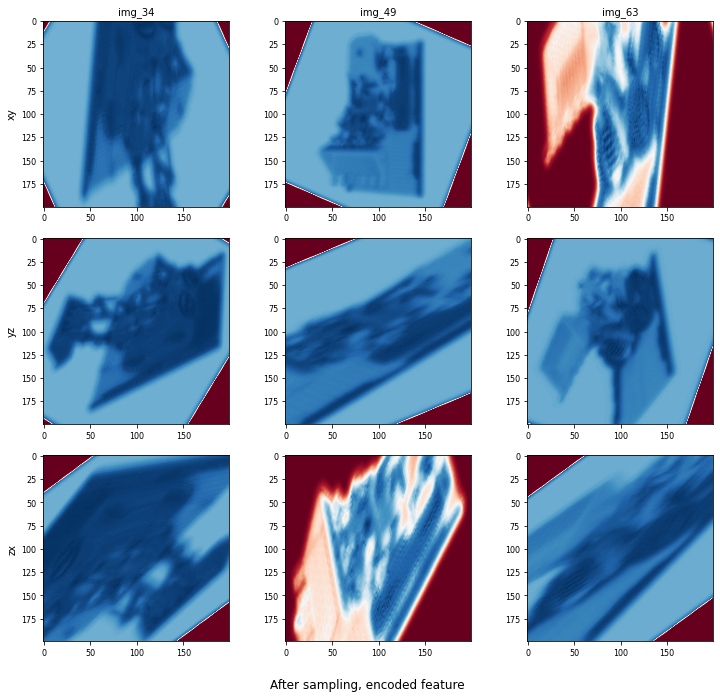

In [39]:
channels = 15
splits = [0, 1, 2]
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=0.3, hspace=0)
vmin, vmax = 1e6, -1e6
for i in splits:
    for j in splits:
        sampling_feats[i, j] = (sampling_feats[i, j] - sampling_feats[i, j].min()) / (sampling_feats[i, j].max() - sampling_feats[i, j].min())
    
    vmin = min(sampling_feats[i, j].min().item(), vmin)
    vmax = max(sampling_feats[i, j].max().item(), vmax)

for i in splits:
    for j in splits:
        axes[i, j].imshow(sampling_feats[i, j][channel].detach().numpy(), cmap='RdBu')
        axes[i, j].xaxis.set_tick_params(labelsize=8)
        axes[i, j].yaxis.set_tick_params(labelsize=8)

rows = ['xy', 'yz', 'zx']
cols = [f'img_{i}' for i in [34, 49, 63]]
for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=90, fontsize=10)

for ax, col in zip(axes[0], cols):
    ax.set_title(col, fontsize=10)

plt.suptitle('After sampling, encoded feature', y=0.1)
plt.show()